In [81]:
import pandas as pd

file_path = 'Preliminary-2020-National-Summary-Clinic-Table.xlsx'
data = pd.ExcelFile(file_path)
clinic_data = data.parse('Clinic Table Data Records')

# Display 
clinic_data.head()

# Replace any cell containing '*'
clinic_data = clinic_data.replace(to_replace=r'\*', value='', regex=True)


clinic_data.head()

,OrderID,CurrentClinicName1,CurrentClinicName2,CurrentClinicCity,CurrentClinicState,MedicalDirector,ND_NumIntentRet1,ND_NumIntentRet2,ND_NumIntentRet3,ND_NumIntentRet4,...,ReasonUnexplained,DonorEggService,DonatedEmbryoService,EmbryoCryoService,EggCryoService,GestCarrierService,SARTmember,LabAccred,NumResearch,CurrentStateAbbrev
0,1,ALABAMA FERTILITY SPECIALISTS,NaN,BIRMINGHAM,ALABAMA,"Mamie R. McLean, MD",102,48,36,31,...,9,Yes,Yes,Yes,Yes,Yes,Yes,Yes,0,AL
1,2,UNIVERSITY OF ALABAMA AT BIRMINGHAM,REPRODUCTIVE ENDOCRINOLOGY AND INFERTILITY,BIRMINGHAM,ALABAMA,"Deidre D Gunn, MD",21,10,9,7,...,9,Yes,Yes,Yes,Yes,Yes,Yes,Yes,0,AL
2,3,FERTILITY INSTITUTE OF NORTH ALABAMA,NaN,HUNTSVILLE,ALABAMA,"Brett Davenport, MD",17,5,,,...,5,Yes,No,Yes,Yes,Yes,No,Yes,0,AL
3,4,CENTER FOR REPRODUCTIVE MEDICINE,NaN,MOBILE,ALABAMA,"George T. Koulianos, MD",54,61,20,18,...,3,Yes,Yes,Yes,Yes,Yes,Yes,Yes,0,AL
4,5,"KATIE OSTROM MD, LLC",NaN,HOMER,ALASKA,"Gary Levy, MD",0,0,0,0,...,/ 16,Yes,No,Yes,Yes,Yes,No,No,0,AK


# Predict Live-Birth Rates Using K-NN​

In [83]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor


# Combine counts for numeric predictors
columns_to_convert = [
    'ND_NumIntentRet1', 'ND_NumIntentRet2', 'ND_NumIntentRet3', 'ND_NumIntentRet4',
    'ND_NumRetrieve1', 'ND_NumRetrieve2', 'ND_NumRetrieve3', 'ND_NumRetrieve4',
    'ND_NumTrans1', 'ND_NumTrans2', 'ND_NumTrans3', 'ND_NumTrans4',
    'ND_RetrieveLB1', 'ND_RetrieveLB2', 'ND_RetrieveLB3', 'ND_RetrieveLB4'
]

# Convert relevant columns to numeric
for col in columns_to_convert:
    clinic_data[col] = pd.to_numeric(clinic_data[col], errors='coerce')

# columns into totals
clinic_data['Total_NumIntentRet'] = clinic_data[['ND_NumIntentRet1', 'ND_NumIntentRet2', 'ND_NumIntentRet3', 'ND_NumIntentRet4']].sum(axis=1, skipna=True)
clinic_data['Total_NumRetrieve'] = clinic_data[['ND_NumRetrieve1', 'ND_NumRetrieve2', 'ND_NumRetrieve3', 'ND_NumRetrieve4']].sum(axis=1, skipna=True)
clinic_data['Total_NumTrans'] = clinic_data[['ND_NumTrans1', 'ND_NumTrans2', 'ND_NumTrans3', 'ND_NumTrans4']].sum(axis=1, skipna=True)

# To avoid dividing by zero
clinic_data['Total_NumRetrieve'] = clinic_data['Total_NumRetrieve'].replace(0, np.nan)

clinic_data['Weighted_RetrieveLB'] = (
    clinic_data[['ND_RetrieveLB1', 'ND_RetrieveLB2', 'ND_RetrieveLB3', 'ND_RetrieveLB4']].multiply(
        clinic_data[['ND_NumRetrieve1', 'ND_NumRetrieve2', 'ND_NumRetrieve3', 'ND_NumRetrieve4']].values, axis=1
    ).sum(axis=1, skipna=True) / clinic_data['Total_NumRetrieve']
)

# Drop the original age-specific columns 
columns_to_drop = [
    'ND_NumIntentRet1', 'ND_NumIntentRet2', 'ND_NumIntentRet3', 'ND_NumIntentRet4',
    'ND_NumRetrieve1', 'ND_NumRetrieve2', 'ND_NumRetrieve3', 'ND_NumRetrieve4',
    'ND_NumTrans1', 'ND_NumTrans2', 'ND_NumTrans3', 'ND_NumTrans4',
    'ND_RetrieveLB1', 'ND_RetrieveLB2', 'ND_RetrieveLB3', 'ND_RetrieveLB4'
]
clinic_data1 = clinic_data.drop(columns=columns_to_drop, errors='ignore')


predictor_columns = ['Total_NumIntentRet', 'Total_NumRetrieve', 'Total_NumTrans']
target_column = 'Weighted_RetrieveLB'  # Use the weighted average percentage as the target

# Extract the relevant columns
data = clinic_data1[predictor_columns + [target_column]].copy()
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')


data = data.dropna()

X = data[predictor_columns]
y = data[target_column]

#  feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# split (70:30 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

# Linear Regression model
lr_model = LinearRegression()

# Fit the model on the training data
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Evaluate the Linear Regression model
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print()
print('Linear Regression Results:')
print('Mean Squared Error:', mse_lr)
print('R^2 Score:', r2_lr)


# Initialize the model with k neighbors
knn_model = KNeighborsRegressor(n_neighbors=12)

knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)


mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print('\nK-NN Regression Results:')
print('Mean Squared Error:', mse_knn)
print('R^2 Score:', r2_knn)


Linear Regression Results:
Mean Squared Error: 198.55895725254257
R^2 Score: 0.1377320868783548

K-NN Regression Results:
Mean Squared Error: 85.67186378645924
R^2 Score: 0.6279588681238095


In [84]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': np.arange(1, 20)}

grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)


print("Best n_neighbors:", grid_search.best_params_)
print("Best R^2 Score:", grid_search.best_score_)

Best n_neighbors: {'n_neighbors': 12}
Best R^2 Score: 0.634163728238988


1.) Our analysis predcicts live birth success rates with 62.80% accuracy using total retrievals, transfers, and intended cycles as predictors.
2.) Clinics with higher retrievals and transfers probably achieve better outcomes.
3.) K-NN outperforms linear regression for this dataset, both in terms of MSE and R².
Relationships in the data are likely nonlinear and that a distance-based, non-parametric model like K-NN is more appropriate. Its low R² and high MSE suggest that the dataset may not have a simple linear relationship between the predictors and the target

In [86]:
# list of predictor features
predictor_columns = ['Total_NumIntentRet', 'Total_NumRetrieve', 'Total_NumTrans']

# target feature
target_column = 'Weighted_RetrieveLB'

# All features are weighted because some of the data is split by age ranges. 
# This ensures that it reflects the overall performance while accounting for the contribution of each age group proportionally.

# Predicting Efficiency Ratios in ART Clinics Using K-NN​

K-NN Regression Results:
Mean Squared Error: 0.01
R² Score: 0.92


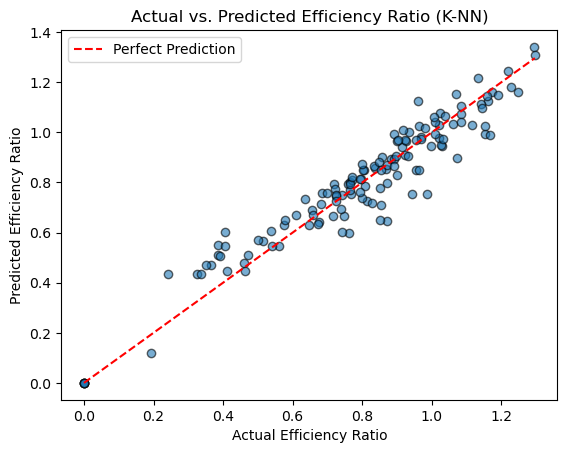

In [88]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

columns_to_convert = [
    'ND_NumTrans1', 'ND_NumTrans2', 'ND_NumTrans3', 'ND_NumTrans4',
    'ND_NumRetrieve1', 'ND_NumRetrieve2', 'ND_NumRetrieve3', 'ND_NumRetrieve4',
    'ND_NumIntentRet1', 'ND_NumIntentRet2', 'ND_NumIntentRet3', 'ND_NumIntentRet4',
    'ND_TransLB1', 'ND_TransLB2', 'ND_TransLB3', 'ND_TransLB4',
    'ND_IntentRetLB1', 'ND_IntentRetLB2', 'ND_IntentRetLB3', 'ND_IntentRetLB4'
]

for col in columns_to_convert:
    clinic_data[col] = pd.to_numeric(clinic_data[col], errors='coerce')


# Transfers total
clinic_data['ND_NumTransAll'] = clinic_data[['ND_NumTrans1', 'ND_NumTrans2', 'ND_NumTrans3', 'ND_NumTrans4']].sum(axis=1, skipna=True)
# Retrievals total
clinic_data['ND_NumRetrieveAll'] = clinic_data[['ND_NumRetrieve1', 'ND_NumRetrieve2', 'ND_NumRetrieve3', 'ND_NumRetrieve4']].sum(axis=1, skipna=True)
# Intended retrievals total
clinic_data['ND_NumIntentRetAll'] = clinic_data[['ND_NumIntentRet1', 'ND_NumIntentRet2', 'ND_NumIntentRet3', 'ND_NumIntentRet4']].sum(axis=1, skipna=True)

# Weighted average for transfers
clinic_data['ND_TransLBAll'] = (
    clinic_data[['ND_TransLB1', 'ND_TransLB2', 'ND_TransLB3', 'ND_TransLB4']].multiply(
        clinic_data[['ND_NumTrans1', 'ND_NumTrans2', 'ND_NumTrans3', 'ND_NumTrans4']].values, axis=1
    ).sum(axis=1, skipna=True) / clinic_data['ND_NumTransAll']
).fillna(0)

# Weighted average for retreivals
clinic_data['ND_IntentRetLBAll'] = (
    clinic_data[['ND_IntentRetLB1', 'ND_IntentRetLB2', 'ND_IntentRetLB3', 'ND_IntentRetLB4']].multiply(
        clinic_data[['ND_NumRetrieve1', 'ND_NumRetrieve2', 'ND_NumRetrieve3', 'ND_NumRetrieve4']].values, axis=1
    ).sum(axis=1, skipna=True) / clinic_data['ND_NumRetrieveAll']
).fillna(0)

# Calculate efficiency ratio 
clinic_data['Efficiency_Ratio'] = clinic_data['ND_NumTransAll'] / clinic_data['ND_NumRetrieveAll']
clinic_data['Efficiency_Ratio'] = clinic_data['Efficiency_Ratio'].replace([np.inf, -np.inf], np.nan).fillna(0)

# Ratio of transfers to intended retrievals
clinic_data['Ratio_TransToIntent'] = clinic_data['ND_NumTransAll'] / clinic_data['ND_NumIntentRetAll']
clinic_data['Ratio_TransToIntent'] = clinic_data['Ratio_TransToIntent'].replace([np.inf, -np.inf], np.nan).fillna(0)


required_cols = ['ND_NumRetrieveAll', 'ND_NumTransAll', 'ND_IntentRetLBAll', 'ND_TransLBAll', 'Efficiency_Ratio', 'Ratio_TransToIntent']
clinic_data = clinic_data.dropna(subset=required_cols)

predictor_columns = ['ND_NumRetrieveAll', 'ND_NumTransAll', 'ND_IntentRetLBAll', 'ND_TransLBAll', 'Ratio_TransToIntent']
target_column = 'Efficiency_Ratio'

X = clinic_data[predictor_columns]
y = clinic_data[target_column]

# Preprocess 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)


knn_model = KNeighborsRegressor(n_neighbors=6)
knn_model.fit(X_train, y_train)


y_pred_knn = knn_model.predict(X_test)

# evaluate
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print('K-NN Regression Results:')
print(f'Mean Squared Error: {mse_knn:.2f}')
print(f'R² Score: {r2_knn:.2f}')


plt.scatter(y_test, y_pred_knn, alpha=0.6, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.title('Actual vs. Predicted Efficiency Ratio (K-NN)')
plt.xlabel('Actual Efficiency Ratio')
plt.ylabel('Predicted Efficiency Ratio')
plt.legend()
plt.show()


In [89]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': np.arange(1, 20)}

grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)


print("Best n_neighbors:", grid_search.best_params_)
print("Best R^2 Score:", grid_search.best_score_)

Best n_neighbors: {'n_neighbors': 6}
Best R^2 Score: 0.8878783836082601


In [90]:
# Break down of features
predictor_columns = [
    'ND_NumRetrieveAll',       # Total number of retrievals across all age groups
    'ND_NumTransAll',          # Total number of transfers across all age groups
    'ND_IntentRetLBAll',       # Weighted average percentage of intended retrievals resulting in live births
    'ND_TransLBAll',           # Weighted average percentage of transfers resulting in live births
    'Ratio_TransToIntent'      # Ratio of transfers to intended retrievals
]

# Target feature
target_column = 'Efficiency_Ratio'  # Efficiency of retrievals converted into transfers


print("Predictor Features:", predictor_columns)
print("Target Feature:", target_column)

Predictor Features: ['ND_NumRetrieveAll', 'ND_NumTransAll', 'ND_IntentRetLBAll', 'ND_TransLBAll', 'Ratio_TransToIntent']
Target Feature: Efficiency_Ratio
